In [7]:
# !pip install pyspark

# Analysis Part

In [8]:
import pyspark
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [9]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime
from pyspark.sql.functions import approxCountDistinct
from pyspark.sql.functions import col
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

In [10]:
from pyspark.sql import SparkSession

In [11]:
import plotly.graph_objects as go
import plotly.offline as pyo

In [12]:
spark = SparkSession.builder.appName(
  "pandas to spark").getOrCreate()

In [89]:
df_spark = spark.read.option('header', 'true').csv("data/7.csv")

In [90]:
df_spark

DataFrame[block_id: string, id: string, index: string, hash: string, date: string, time: string, failed: string, type: string, sender: string, recipient: string, call_count: string, value: string, value_usd: string, internal_value: string, internal_value_usd: string, fee: string, fee_usd: string, gas_used: string, gas_limit: string, gas_price: string, input_hex: string, nonce: string, v: string, r: string, s: string, version: string, effective_gas_price: string, max_fee_per_gas: string, max_priority_fee_per_gas: string, base_fee_per_gas: string, burned: string, type_2718: string]

In [91]:
df_spark.show()

+--------+--------------+-----+--------------------+----------+-------------------+------+------------------+--------------------+--------------------+----------+------------------+------------------+-------------------+------------------+-----------------+------------------+--------+---------+-------------+--------------------+--------+----+--------------------+--------------------+-------+-------------------+---------------+------------------------+----------------+-----------------+---------+
|block_id|            id|index|                hash|      date|               time|failed|              type|              sender|           recipient|call_count|             value|         value_usd|     internal_value|internal_value_usd|              fee|           fee_usd|gas_used|gas_limit|    gas_price|           input_hex|   nonce|   v|                   r|                   s|version|effective_gas_price|max_fee_per_gas|max_priority_fee_per_gas|base_fee_per_gas|           burned|type_2718

In [92]:
df_spark.columns

['block_id',
 'id',
 'index',
 'hash',
 'date',
 'time',
 'failed',
 'type',
 'sender',
 'recipient',
 'call_count',
 'value',
 'value_usd',
 'internal_value',
 'internal_value_usd',
 'fee',
 'fee_usd',
 'gas_used',
 'gas_limit',
 'gas_price',
 'input_hex',
 'nonce',
 'v',
 'r',
 's',
 'version',
 'effective_gas_price',
 'max_fee_per_gas',
 'max_priority_fee_per_gas',
 'base_fee_per_gas',
 'burned',
 'type_2718']

In [93]:
columns_to_drop = ['id','type_2718','date','v','r','s','version']
df = df_spark.drop(*columns_to_drop)

In [94]:
df.show()

+--------+-----+--------------------+-------------------+------+------------------+--------------------+--------------------+----------+------------------+------------------+-------------------+------------------+-----------------+------------------+--------+---------+-------------+--------------------+--------+-------------------+---------------+------------------------+----------------+-----------------+
|block_id|index|                hash|               time|failed|              type|              sender|           recipient|call_count|             value|         value_usd|     internal_value|internal_value_usd|              fee|           fee_usd|gas_used|gas_limit|    gas_price|           input_hex|   nonce|effective_gas_price|max_fee_per_gas|max_priority_fee_per_gas|base_fee_per_gas|           burned|
+--------+-----+--------------------+-------------------+------+------------------+--------------------+--------------------+----------+------------------+------------------+------

In [95]:
df.count()

100

In [96]:
df.describe().show()

+-------+-----------+------------------+--------------------+-------------------+------+------------------+--------------------+--------------------+-----------------+--------------------+-----------------+--------------------+------------------+--------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+--------------------+--------------------+------------------------+----------------+--------------------+
|summary|   block_id|             index|                hash|               time|failed|              type|              sender|           recipient|       call_count|               value|        value_usd|      internal_value|internal_value_usd|                 fee|           fee_usd|          gas_used|         gas_limit|           gas_price|           input_hex|             nonce| effective_gas_price|     max_fee_per_gas|max_priority_fee_per_gas|base_fee_per_gas|              burned|
+-------+---------

In [97]:
# convert numeric columns to appropriate data types
df = df.withColumn("block_id", df["block_id"].cast("integer"))
df = df.withColumn("call_count", df["call_count"].cast("integer"))
df = df.withColumn("value", df["value"].cast("float"))
df = df.withColumn("value_usd", df["value_usd"].cast("float"))
df = df.withColumn("internal_value", df["internal_value"].cast("float"))
df = df.withColumn("internal_value_usd", df["internal_value_usd"].cast("float"))
df = df.withColumn("gas_used", df["gas_used"].cast("integer"))
df = df.withColumn("fee", df["fee"].cast("float"))
df = df.withColumn("fee_usd", df["fee_usd"].cast("float"))
df = df.withColumn("gas_limit", df["gas_limit"].cast("float"))
df = df.withColumn("gas_price", df["gas_price"].cast("float"))
df = df.withColumn("nonce", df["nonce"].cast("integer"))
df = df.withColumn("effective_gas_price", df["effective_gas_price"].cast("float"))
df = df.withColumn("max_fee_per_gas", df["max_fee_per_gas"].cast("float"))
df = df.withColumn('max_priority_fee_per_gas', df['max_priority_fee_per_gas'].cast("integer"))
df = df.withColumn("base_fee_per_gas", df["base_fee_per_gas"].cast("integer"))

In [98]:
df.schema

StructType([StructField('block_id', IntegerType(), True), StructField('index', StringType(), True), StructField('hash', StringType(), True), StructField('time', StringType(), True), StructField('failed', StringType(), True), StructField('type', StringType(), True), StructField('sender', StringType(), True), StructField('recipient', StringType(), True), StructField('call_count', IntegerType(), True), StructField('value', FloatType(), True), StructField('value_usd', FloatType(), True), StructField('internal_value', FloatType(), True), StructField('internal_value_usd', FloatType(), True), StructField('fee', FloatType(), True), StructField('fee_usd', FloatType(), True), StructField('gas_used', IntegerType(), True), StructField('gas_limit', FloatType(), True), StructField('gas_price', FloatType(), True), StructField('input_hex', StringType(), True), StructField('nonce', IntegerType(), True), StructField('effective_gas_price', FloatType(), True), StructField('max_fee_per_gas', FloatType(), T

In [99]:
df.show()

+--------+-----+--------------------+-------------------+------+------------------+--------------------+--------------------+----------+-------------+---------+--------------+------------------+-------------+---------+--------+---------+------------+--------------------+------+-------------------+---------------+------------------------+----------------+-----------------+
|block_id|index|                hash|               time|failed|              type|              sender|           recipient|call_count|        value|value_usd|internal_value|internal_value_usd|          fee|  fee_usd|gas_used|gas_limit|   gas_price|           input_hex| nonce|effective_gas_price|max_fee_per_gas|max_priority_fee_per_gas|base_fee_per_gas|           burned|
+--------+-----+--------------------+-------------------+------+------------------+--------------------+--------------------+----------+-------------+---------+--------------+------------------+-------------+---------+--------+---------+------------+

In [100]:
num_cols = []
cat_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType()":
        cat_cols.append(s.name)
    
    if data_type == "LongType()" or data_type == "DoubleType()" or data_type=='IntegerType()':
        num_cols.append(s.name)

In [101]:
print(num_cols)
print(cat_cols)

['block_id', 'call_count', 'gas_used', 'nonce', 'max_priority_fee_per_gas', 'base_fee_per_gas']
['index', 'hash', 'time', 'failed', 'type', 'sender', 'recipient', 'input_hex', 'burned']


In [102]:
for i in cat_cols:
    num_unique = df.select(approxCountDistinct(f"{i}")).collect()[0][0]
    print(f"{i} has {num_unique} unique values")

c:\Users\JAINAM\anaconda3\lib\site-packages\pyspark\sql\functions.py:2610: FutureWarning:

Deprecated in 2.1, use approx_count_distinct instead.



index has 101 unique values
hash has 92 unique values
time has 1 unique values
failed has 2 unique values
type has 3 unique values
sender has 95 unique values
recipient has 67 unique values
input_hex has 78 unique values
burned has 78 unique values


In [103]:
def count_missing(df, col):
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()

In [104]:
print("[missing values]\n")
for col in df.columns:
    missing_count = count_missing(df, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))

[missing values]

index: 1
hash: 1
sender: 1
fee: 1
fee_usd: 1
gas_used: 1
gas_limit: 1
gas_price: 1
input_hex: 21
nonce: 1
effective_gas_price: 1
max_fee_per_gas: 5
max_priority_fee_per_gas: 7
base_fee_per_gas: 100
burned: 1


In [107]:
df = df.fillna(0)
df.show()

+--------+-----+--------------------+-------------------+------+------------------+--------------------+--------------------+----------+-------------+---------+--------------+------------------+-------------+---------+--------+---------+------------+--------------------+------+-------------------+---------------+------------------------+----------------+-----------------+
|block_id|index|                hash|               time|failed|              type|              sender|           recipient|call_count|        value|value_usd|internal_value|internal_value_usd|          fee|  fee_usd|gas_used|gas_limit|   gas_price|           input_hex| nonce|effective_gas_price|max_fee_per_gas|max_priority_fee_per_gas|base_fee_per_gas|           burned|
+--------+-----+--------------------+-------------------+------+------------------+--------------------+--------------------+----------+-------------+---------+--------------+------------------+-------------+---------+--------+---------+------------+

## Analysis of the Transaction Type

In [108]:
type_analysis = df.groupBy("type").agg(F.sum("gas_used").alias("total_gas_used"),F.sum("value_usd").alias("total_value_txn_usd"),F.sum("effective_gas_price").alias("total_effective_gas_price"),F.sum("fee_usd").alias("total_fee_usd"),F.sum("call_count").alias("total_call_count"))

type_analysis_pd = type_analysis.toPandas()

In [109]:
type_analysis.show()

+------------------+--------------+-------------------+-------------------------+------------------+----------------+
|              type|total_gas_used|total_value_txn_usd|total_effective_gas_price|     total_fee_usd|total_call_count|
+------------------+--------------+-------------------+-------------------------+------------------+----------------+
|synthetic_coinbase|             0|      168.806640625|                      0.0|               0.0|               1|
|         call_tree|       7092877|  35265.36172628403|        4.251073896448E12|1121.5744242668152|             532|
|              call|       1788338| 23420.247757911682|        4.019538182144E12|  284.058758020401|              48|
+------------------+--------------+-------------------+-------------------------+------------------+----------------+



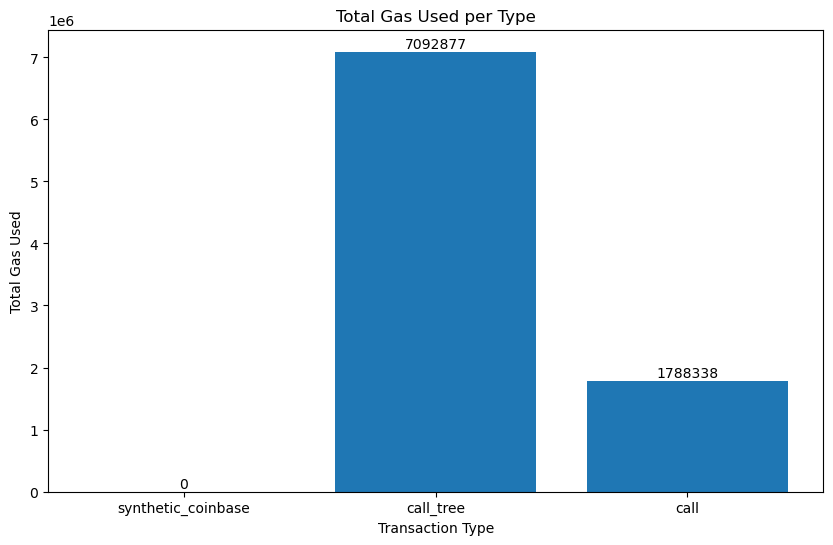

In [110]:

# Plot the data using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(type_analysis_pd["type"], type_analysis_pd["total_gas_used"])
plt.xlabel("Transaction Type")
plt.ylabel("Total Gas Used")
plt.title("Total Gas Used per Type")
for i, value in enumerate(type_analysis_pd['total_gas_used']):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()

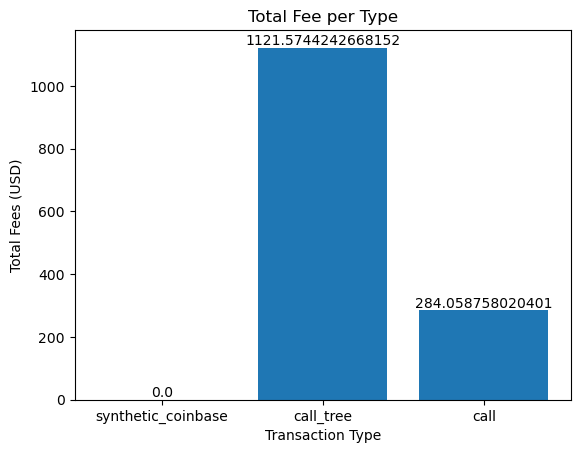

In [111]:
plt.bar(type_analysis_pd["type"], type_analysis_pd["total_fee_usd"])
plt.xlabel("Transaction Type")
plt.ylabel("Total Fees (USD)")
plt.title("Total Fee per Type")
for i, value in enumerate(type_analysis_pd['total_fee_usd']):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()

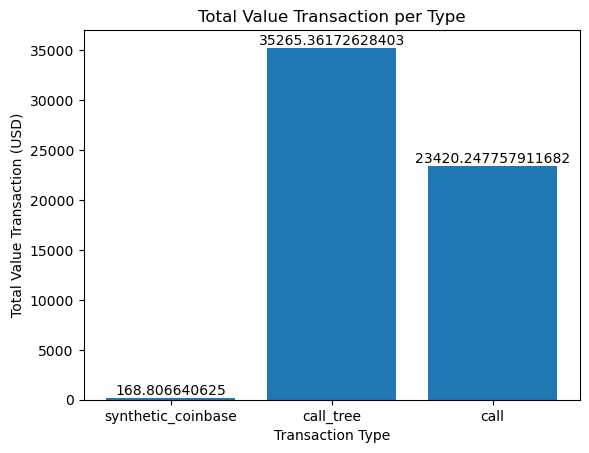

In [112]:
plt.bar(type_analysis_pd["type"], type_analysis_pd["total_value_txn_usd"])
plt.xlabel("Transaction Type")
plt.ylabel("Total Value Transaction (USD)")
plt.title("Total Value Transaction per Type")
for i, value in enumerate(type_analysis_pd['total_value_txn_usd']):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()

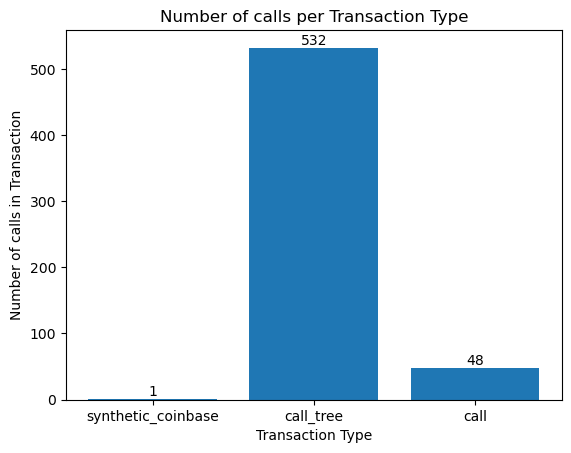

In [113]:
plt.bar(type_analysis_pd["type"], type_analysis_pd["total_call_count"])
plt.xlabel("Transaction Type")
plt.ylabel("Number of calls in Transaction")
plt.title("Number of calls per Transaction Type")
for i, value in enumerate(type_analysis_pd['total_call_count']):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()
plt.show()

## Analysis of count of categorical features

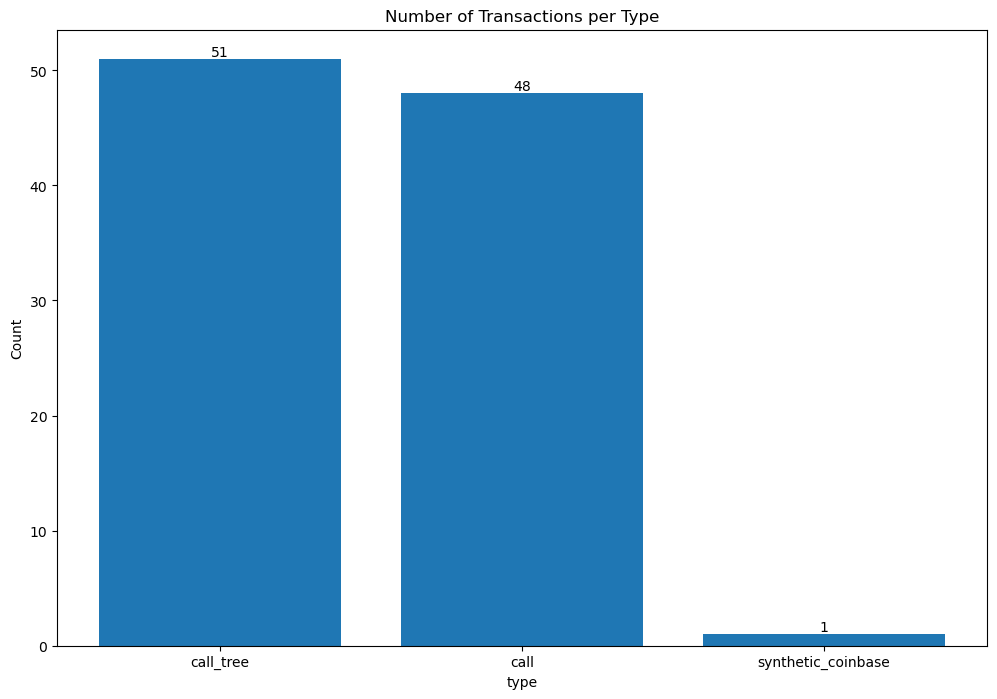

In [35]:
type_count = df.groupBy('type').count()
type_count = type_count.sort('count', ascending=False)
type_count = type_count.toPandas()
plt.figure(figsize=(12,8))
plt.bar(type_count['type'],type_count['count'])
plt.xlabel('type')
plt.ylabel('Count')
plt.title('Number of Transactions per Type')
for i, value in enumerate(type_count['count']):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()

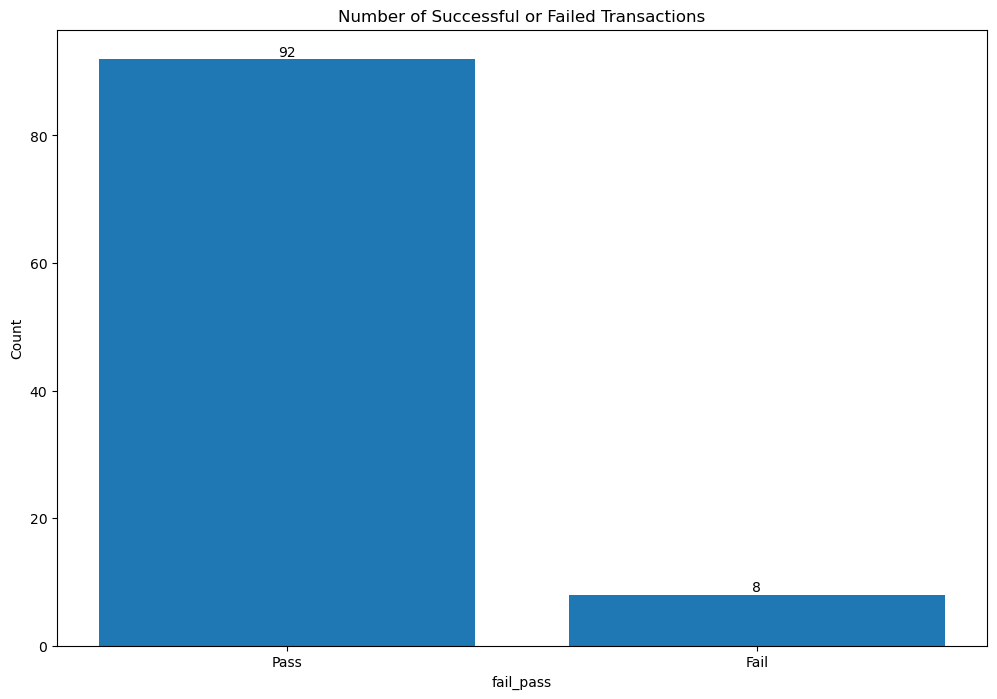

In [36]:
df = df.withColumn("fail_pass", when(df["failed"] == True, 'Fail').otherwise('Pass'))
failure_count = df.groupBy('fail_pass').count()
failure_count = failure_count.sort('count', ascending=False)
failure_count = failure_count.toPandas()
plt.figure(figsize=(12,8))
plt.bar(failure_count['fail_pass'],failure_count['count'])
plt.xlabel('fail_pass')
plt.ylabel('Count')
plt.title('Number of Successful or Failed Transactions')
for i, value in enumerate(failure_count['count']):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()

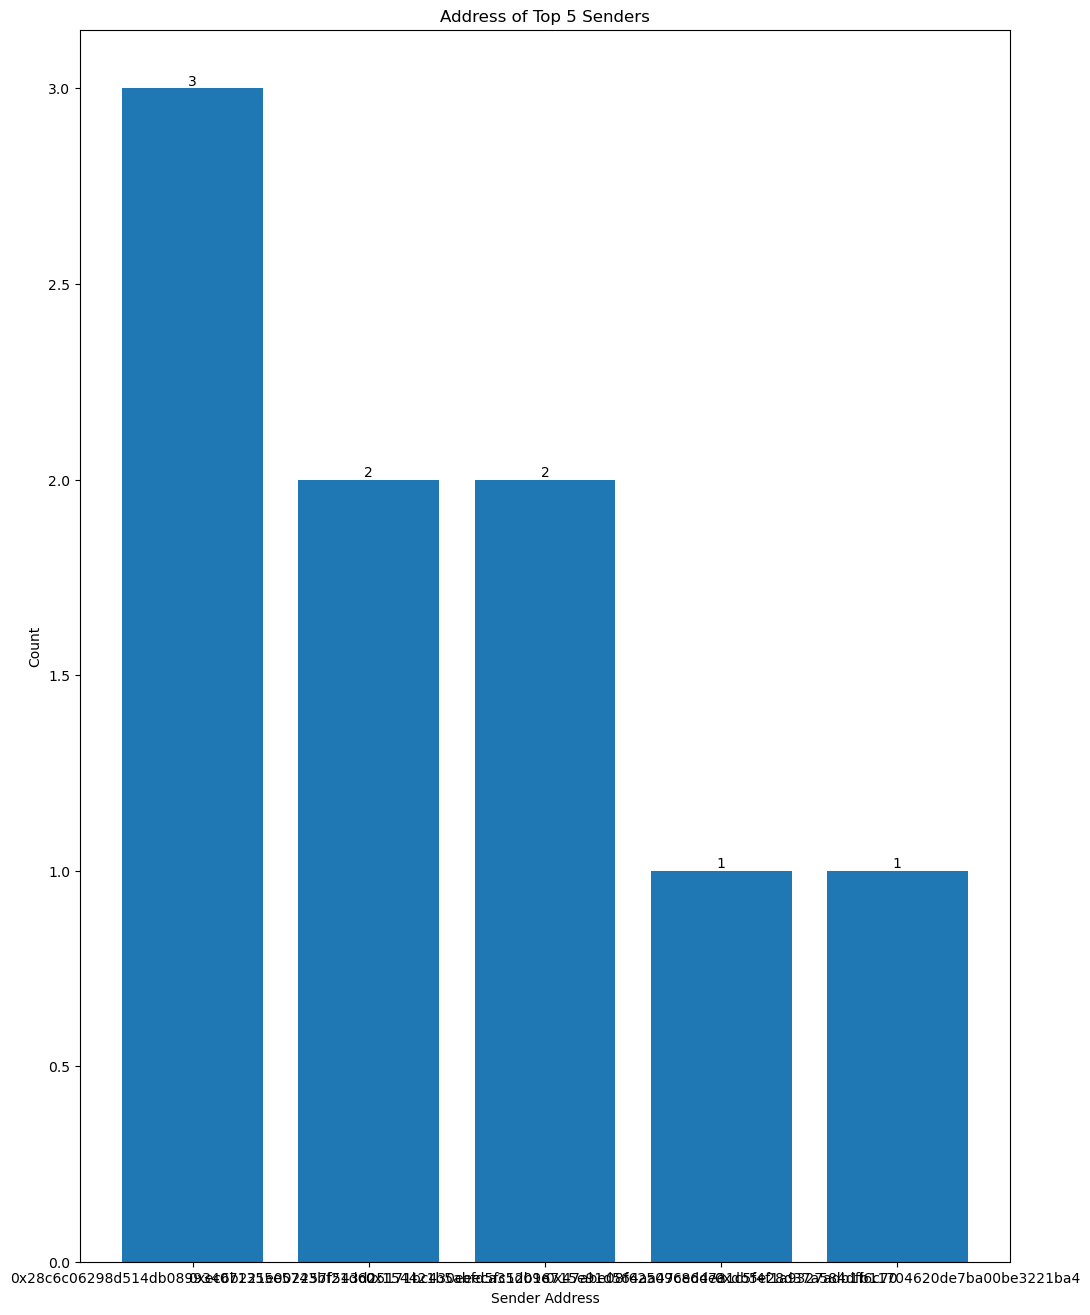

In [37]:
# Not Sure about including
l = df.groupBy('Sender').count()
l1 = l.sort('count', ascending=False).limit(5)
l1 = l1.toPandas()
plt.figure(figsize=(12,16))
plt.bar(l1['Sender'],l1['count'])
plt.xlabel('Sender Address')
plt.ylabel('Count')
plt.title('Address of Top 5 Senders')
for i, value in enumerate(l1['count']):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.show()

## Calculation Analysis

In [38]:
total_gas = df.select(F.sum("gas_used")).collect()[0][0]

# Create the indicator chart plot
fig1 = go.Figure(go.Indicator(
    # domain = {'x': [0, 1], 'y': [0, 1]},
    mode="gauge+number",
    value=total_gas,
    number={"valueformat": ",.0f",'prefix': "\u20B9"},
    title={"text": "Total Gas Used"}
))

# Show the plot
fig1.show()
pyo.plot(fig1, filename='images/totalGas.html', auto_open=False)

'figure.html'

In [114]:
total_value_transferred = df.agg(F.sum("value_usd")).collect()[0][0]

fig2 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=total_value_transferred,
    number={"valueformat": ",.0f"},
    title={"text": "Total Value of Ethereum Transferred (USD)"}
))

# Show the plot
fig2.show()
pyo.plot(fig2, filename='images/totalvaluetransac.html', auto_open=False)

'images/totalvaluetransac.html'

In [116]:
total_transactions = df.count()
fig2 = go.Figure(go.Indicator(
    mode="gauge+number",
    value=total_transactions,
    number={"valueformat": ",.0f"},
    title={"text": "Total Number of Ethereum Transactions (USD)"}
))

# Show the plot
fig2.show()
pyo.plot(fig2, filename='images/totalnumbertxns.html', auto_open=False)

'images/totalnumbertxns.html'